# TP3 : ADMM for image reconstruction

### by : LAZARD Benjamin & HAMIDOU Wissem

## Introduction

In this project, we address the problem of computing a picture shot by a photo camera, as it would be without camera movement, i.e without blur.

Physically, the blur effect corresponds to a movement of the camera, while the light is still sending photons to the sensor, resulting in an overlay of what should have been different pictures (same scene, but under different angles).

To model this effect, we can consider it a linear transformation, and thus state the blur effect is nothing but a convolution.
The resulting (observed) image $y$ is equal to $\mathcal{H}\star x$ where $\mathcal{H}$ is the filter matrix (in our example a diagonal move), and $x$ is the original picture. This can be simply writed as a product $y=Hx$ (but with a different $H$).

We will try, given an estimated $H$ from an observed image $y$, to reverse the problem, and estimate the original $x$. It is an optimisation problem, because inverting $H$ is not enough : we must guarantee that the computed image is smooth enough which can be done with a constraint $|x_{i+1}-x_{i}| \leq \mbox{threshold} \; \forall i$, and that every single pixel is "physically sound" (a positive value).

Because of all this constraints, we will use ADMM (Alternative Direction Method of Multipliers), which allows for the separation of the minimization steps of all variables, while solving the dual problem.

## Relevant imports

In [94]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy
import scipy.sparse as sparse
import scipy.sparse.linalg as splinalg
from math import inf
from time import time

#beautify plots
from matplotlib import rc
rc('text', usetex=True)

## Downloading relevant data

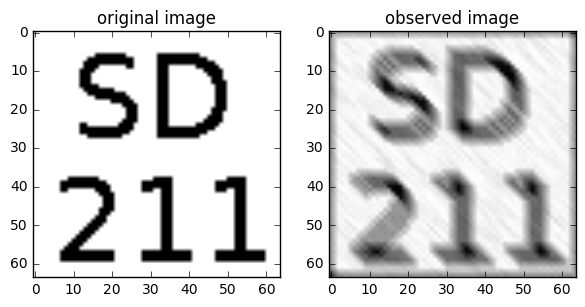

In [64]:
# Open the data stored in a  local file with pickle format
data = pickle.load(open('data.pk','rb'), encoding='latin1')

# Download the other matrixes
filter_ = data.get('filter') # blur filter
T = data.get('T').toarray() # anisotropic variation penalization matrix
H = data.get('H').toarray() # matrix representation of filter.

# Download the images sets as vectors
original = data.get('original')
observations = data.get('observations')

# observing them
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,10))
ax1.set_title("original image")
ax2.set_title("observed image")
ax1.imshow(original, cmap='gray')
ax2.imshow(observations, cmap='gray')

# ADMM-like problem formulation

The goal is to find a simplified expression of the problem $$\underset{x}{arg min} \left( \frac{1}{2}\|y - Hx\|_2^2  + \beta \|Tx\|_1 + i_{{[0,1]}^p}(x)\right)$$ to prove it can be solved with ADMM method.

First let us recap this equation to understand it right : 

- $\|y - Hx\|$ aimes at finding the image x, which, after applying the "blur filter" $H$, is the closest to the image $y$ we have
- $\beta \|Tx\|_1$ is a penalization aimed at smoothing out the solution. to make it "anisotropic".
- $i_{{[0,1]}^p}(x)$ is a constraint that guarantee every single point in the image $x$ is $>0$. Indeed the result must be a realistic image with positive pixel values.

We can put it in the classic ADMM form 
$$\left\{\begin{array}{ll}
        \underset{x}{min}\left( f(x) + g(z)\right) \\
        \mbox{under the constraint } Ax = z
\end{array}\right.$$

To do so, we have to consider rhe following settings :
- $z = \begin{pmatrix} z_1 \\ z_2\\ \end{pmatrix}$
with $z_1 = x$ and $z_2 = Tx$
-  $A = \begin{pmatrix} I \\ T\\ \end{pmatrix}$
- $f : x \mapsto \frac{1}{2}\|y - Hx\|_2^2$
- $g : z \mapsto i_{{[0,1]}^p}(z_1) + \beta \|z_2\|_1 $

# Expressing the dual form
Now we can write the lagrangian of this problem.
$$\mathcal{L}(x, z^k, \gamma^k) = f(x) + g(z) + \gamma^T(Ax-z) +\frac{\rho}{2}\|Ax-z\|_2^2$$

Just out of curiousity, we can state that the lagrangian of the 3rd problem is however:
$$ \mathcal{L}(x, \lambda_1, \lambda_2) = \frac{1}{2}\|y - Hx\|_2^2  + \beta \|Tx\|_1 + <\lambda_1, -x> + <\lambda_2, x - \mathbb{1}_{p}>$$

## Minimization along $x$
Now let us write the minimization step of the algorithm on the variable x.
We have $$ x^{k+1} = \underset{x}{arg min} \ \mathcal{L}_{p}(x, z^k, \gamma^k)$$
We can write $\frac{\partial \mathcal{L}_p}{\partial x} = 0$ thus $-H^T(y-Hx) + A^T\gamma + \rho A^T(Ax-z^k) = 0$
From this we get $$x^{k+1} = \left(H^TH + \rho A^TA\right)^{-1}\left(H^Ty- A^T\gamma + \rho A^T z^k\right)$$

Of course, in this form, we assume that H and A are full rank matrices. Whether the solution is unique or not matters not, we want $\left(H^TH + \rho A^TA\right)x^{k+1} = \left(H^Ty- A^T\gamma + \rho A^T z^k\right)$

## Minimization along $z_1$
Same reasoning here :
$$z_1^{k+1} = \underset{z_1}{arg min} \ \mathcal{L}_{p}(x^{k+1}, z_1, z_2, \gamma^k)$$

We can set $\gamma^{k} = \begin{pmatrix} \gamma_1^{k} \\ \gamma_2^{k}\\ \end{pmatrix}$, and then

we can write $ 0 \in \frac{\partial L_p}{\partial z_1} \Longleftrightarrow - \gamma_1^{k} + \frac{\rho}{2} \frac{\partial \|Ax^{k+1}-z\|^2_2}{\partial z_1} = 0$ under the constraint $ i_{{[0,1]}^p}(z_1)$

It does not look too easy to derivate this on $z_1$ only (or $z_2$ only, which is the next step). We can notice that:

$\begin{align*} 
\|Ax-z\|^2 &= \left|\left|Ax-\begin{pmatrix} z_1 \\ z_2\\ \end{pmatrix}\right|\right|^2 \\
&= \left|\left|\begin{pmatrix} x - z_1 \\ Tx - z_2\\ \end{pmatrix}\right|\right|^2 \\
&=\|x - z_1\|^2 + \|Tx - z_2\|^2
\end{align*}$

Therefore $\begin{align*}
\frac{\rho}{2} \frac{\partial \|Ax-z\|^2_2}{\partial z_1} 
&= \frac{\rho}{2} 2\times(-1)\times(x - z_1)\\
&= \rho(z_1 - x)\\
\end{align*}$

and similarily $\frac{\rho}{2} \frac{\partial \|Ax-z\|^2_2}{\partial z_2} = \rho(z_2 - Tx)$

This leads us to the equation $\rho (z_1^{k+1} -x^{k+1}) - \gamma_1^{k} = 0 \Longleftrightarrow z_1^{k+1} = \left(\frac{\gamma_1^{k}}{\rho} + x^{k+1}\right)$

With the addition of the constraint : $$z_1^{k+1}(i) = \left\{ \begin{array}{lll} \frac{\gamma_1^{k}(i)}{\rho} + x^{k+1}_i \mbox{ if } \frac{\gamma_1^{k}(i)}{\rho} + x^{k+1}_i \in [0,1]\\ 1 \mbox{ if } \frac{\gamma_1^{k}(i)}{\rho} + x^{k+1}_i \geq 1\\0 \mbox{ if } \frac{\gamma_1^{k}(i)}{\rho} + x^{k+1}_i \leq 0 \end{array}\right.$$

## Minimization along $z_2$
Same reasoning here :
$$z_2^{k+1} = \underset{z_2}{arg min} \ \mathcal{L}_{p}(x^{k+1}, z_1, z_2, \gamma^k)$$

Based on what we wrote above, this time, we have $ 0 \in \frac{\partial \mathcal{L}_p}{\partial z_2} \Longleftrightarrow - \gamma_2 + \rho (z_2^{k+1} -Tx^{k+1}) + \beta\frac{\partial \|z_2\|^2_1}{\partial z_2} = 0$.

This yields the following:
$\left\{\begin{array}{lll}
\mbox{if }  z_2^{k+1}(i) >0 \,\;\;\,\;\;\,\;\; \mbox{then}\,\;\;\,\;\;\,\;\; \beta - \gamma_2 + \rho((z_2^{k+1} -Tx^{k+1}))(i) = 0\\
\mbox{if }  z_2^{k+1}(i) <0 \,\;\;\,\;\;\,\;\; \mbox{then}\,\;\;\,\;\;\,\;\;-\beta - \gamma_2 + \rho((z_2^{k+1} -Tx^{k+1}))(i) = 0\\
\mbox{if }  z_2^{k+1}(i) = 0 \,\;\;\,\;\;\,\;\; \mbox{then}\,\;\;\,\;\;\,\;\; \mbox{well nothing to add}
\end{array}\right.$

And then $z_2^{k+1}(i) =
\left\{\begin{array}{lll}
\frac{\gamma_2(i) -\beta}{\rho} + Tx^{k+1}(i)\,\;\;\,\;\;\,\;\;\mbox{if }  \frac{\gamma_2(i) -\beta}{\rho} + Tx^{k+1}(i)  > 0\\
\frac{\gamma_2(i) +\beta}{\rho} + Tx^{k+1}(i) \,\;\;\,\;\;\,\;\;\mbox{if }  \frac{\gamma_2(i) +\beta}{\rho} + Tx^{k+1}(i)  < 0 \\
0 \,\;\;\,\;\;\,\;\;\,\;\;\,\;\;\,\;\;\,\;\;\,\;\;\,\;\;\,\;\;\,\;\;\,\mbox{otherwise }
\end{array}\right.$

## defining next $\gamma$
We have $\gamma^{k+1} = \gamma^{k} + \rho(Ax^{k+1} -z^{k+1})$ with $\gamma^{k} = \begin{pmatrix} \gamma_1^{k} \\ \gamma_2^{k}\\ \end{pmatrix}$

This can be expressed as :
$$\left\{ \begin{array}{lll} \gamma_1^{k+1} = \gamma_1^{k} + \rho(x^k - z_1^k) \\ \gamma_2^{k+1} = \gamma_2^{k} + \rho(Tx^k - z_2^k)  \end{array}\right.$$

# Practical code of ADMM

ADMM computed in 26.82 s


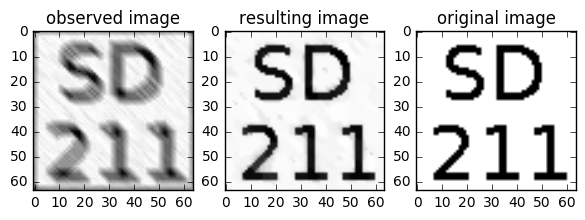

In [65]:
####################
#Formatting data
n, p = T.shape #shape : (2P−K−L) x P in the subject
I = np.identity((p))
A = np.concatenate((np.eye(p), T), axis=0)
K,L = observations.shape
vec = observations.ravel()

####################
#parameters of ADMM computations
ρ = 0.05
β = 0.01
kmax = 100

####################
#ADMM steps

def actu_x(γ, z, y, A, H, ρ, M):
    b = np.dot(H.T,y) - np.dot(A.T, γ) + ρ*np.dot(A.T, z)
    x = splinalg.cg(M, b)
    return x[0]


def actu_z1(γ1, x, ρ):
    z1 = γ1/ρ + x
    for i in range(len(z1)):
        if (z1[i] < 0):
            z1[i] = 0
        if (z1[i] > 1):
            z1[i] = 1
    return z1
    
    
def actu_z2(γ2, T, x, ρ, β):
    M = np.dot(T, x)
    M1 = M + (1/ρ)*(γ2 - β)
    M2 = M + (1/ρ)*(γ2 + β)
    
    z2 = []
    for i in range(len(M)):
        if (M1[i] > 0):
            z2.append(M1[i])
        elif (M2[i] < 0):
            z2.append(M2[i])
        else: 
            z2.append(0)
    return z2
            

def actu_gamma(γ1, γ2, x, z1, z2, T, ρ):
    γ1 = γ1 + ρ*(x - z1)
    γ2 = γ2 + ρ*(np.dot(T, x) - z2)
    return (γ1 , γ2)

####################
#ADMM

def ADMM(γ1, γ2, z1, z2, y, ρ, β, kmax):
    i = 0
    M = np.dot(H.T,H) + ρ*np.dot(A.T,A) # we compute it once, it costs a lot of time to compute it at each iteration
    
    start = time()
    while (i < kmax):
        γ = np.concatenate((γ1,γ2))
        z = np.concatenate((z1,z2))
        x = actu_x(γ, z, y, A, H, ρ, M)
        z1 = actu_z1(γ1, x, ρ)
        z2 = actu_z2(γ2, T, x, ρ, β)
        γ1, γ2 = actu_gamma(γ1, γ2, x, z1, z2, T, ρ)
        i+=1
    
    print("ADMM computed in %0.2f s"%(time()-start)) 
    return x
    
####################
#Practical calculus
γ1 = z1 = np.zeros(p)
γ2 = z2 = np.zeros((2*(p - K)))
result = ADMM(γ1, γ2, z1, z2, vec, ρ, β, kmax)
# and plot
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7,10))
ax1.set_title("observed image")
ax2.set_title("resulting image")
ax3.set_title("original image")
ax1.imshow(observations, cmap='gray')
ax2.imshow(np.reshape(result, (K,L)), cmap='gray')
ax3.imshow(original, cmap='gray')

## Lagrangian and MSE
(let us check the values decrease in a monotonic way)

ADMM computed in 32.62 s


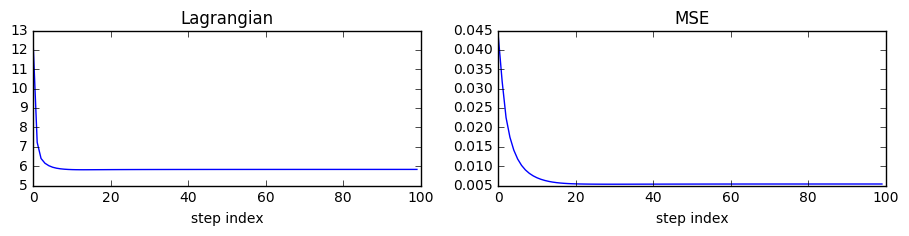

In [70]:
#compute the lagragian with the specific set of parameters of our problem
def lagrangien(x, z1, z2, γ1, γ2, ρ, y, H, A, β):
    γ = np.concatenate((γ1,γ2))
    z = np.concatenate((z1,z2))
    if (np.prod(z1)<0 and np.prod(z1)>1):
        return inf
    else:
        value = 0
        value = value + 0.5 * (np.linalg.norm(y - np.dot(H,x))**2)
        value = value + β * np.sum(np.absolute(z2))
        value = value + np.dot(γ, np.dot(A,x)-z)
        value = value + 0.5 * ρ * (np.linalg.norm(np.dot(A,x)-z)**2)
        return value 

#Same as before, except this time, it computes lagrangian and MSE at each step. 
def ADMM_lag_mse(γ1, γ2, z1, z2, y, ρ, β, kmax, original):
    Lagrangian = [] # values of the augmented lagrangien througout algorithm steps
    MSE = [] # values of the MSE througout algorithm steps
    i = 0
    M = np.dot(H.T,H) + ρ*np.dot(A.T,A) # we compute it once, it costs a lot of time to compute it at each iteration
    
    start = time()
    while (i < kmax):
        γ = np.concatenate((γ1,γ2))
        z = np.concatenate((z1,z2))
        x = actu_x(γ, z, y, A, H, ρ, M)
        z1 = actu_z1(γ1, x, ρ)
        z2 = actu_z2(γ2, T, x, ρ, β)
        γ1, γ2 = actu_gamma(γ1, γ2, x, z1, z2, T, ρ)
        
        Lagrangian.append(lagrangien(x, z1, z2, γ1, γ2, ρ, y, H, A, β))
        MSE.append(np.mean((x-original)**2))
        i+=1
    stop = time()-start
    print("ADMM computed in %0.2f s"%(stop)) 
    return x, Lagrangian, MSE, stop

####################
#Plotting the results
_, Lagrangian, MSE,_ = ADMM_lag_mse(γ1, γ2, z1, z2, vec, ρ, β, kmax, original.ravel())
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 2))
ax1.set_title("Lagrangian")
ax1.set_xlabel("step index")
ax2.set_title("MSE")
ax2.set_xlabel("step index")
ax1.plot(Lagrangian)
ax2.plot(MSE)

We can see the Lagrangian quickly reaches a minimum which unfortunately does not evolve afterwards, until the maximum number of steps. Same thing for MSE. This means that the result is quite satisfying, because there seem not to be any descent direction left for ADMM algorithm to follow. The MSE was reduced by a factor close to 10.

# Influence of $\rho$

ADMM computed in 106.19 s
ADMM computed in 88.00 s
ADMM computed in 67.13 s
ADMM computed in 56.38 s
ADMM computed in 45.92 s
ADMM computed in 33.11 s
ADMM computed in 32.88 s
ADMM computed in 30.86 s
ADMM computed in 30.46 s
ADMM computed in 31.03 s


C:\Users\Benjamin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


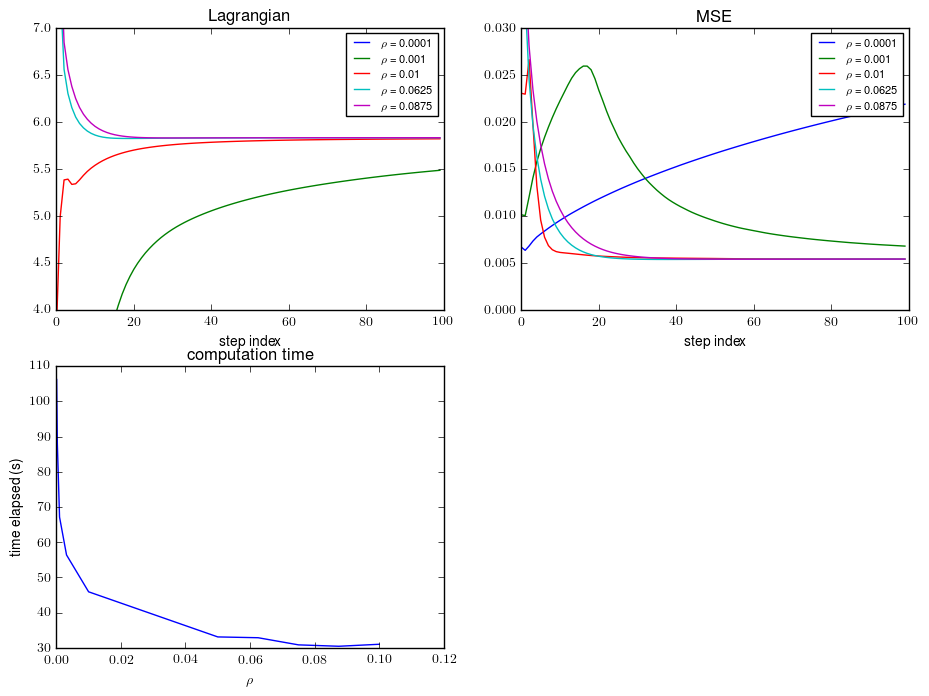

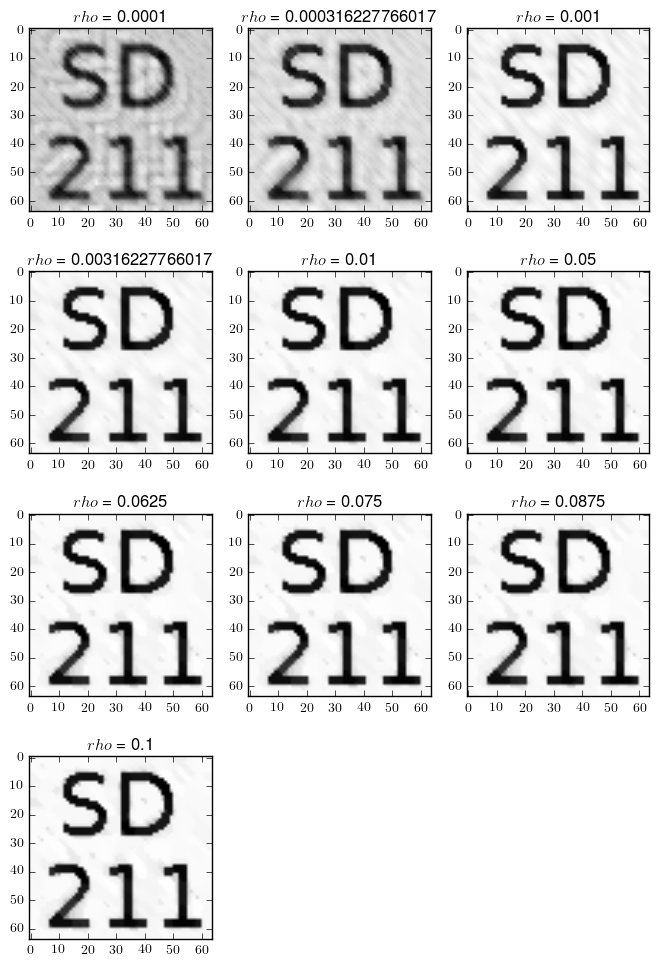

In [142]:
list_ρ = np.concatenate((np.logspace(start=-4, stop=-2 , num=5, base=10), np.linspace(0.05, 0.1, 5)))
list_Lagrangian = []
list_result = []
list_MSE = []
list_time = []

for j in list_ρ:
    result, Lagrangian, MSE, tt = ADMM_lag_mse(γ1, γ2, z1, z2, vec, j, β, kmax, original.ravel())
    list_Lagrangian.append(Lagrangian)
    list_MSE.append(MSE)
    list_result.append(result)
    list_time.append(tt)
    
####################
#Plotting the results
## getting the axes
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 8))
f.delaxes(ax4)
ax1.set_title(r"Lagrangian")
ax1.set_xlabel(r"step index")
ax2.set_title(r"MSE")
ax2.set_xlabel(r"step index")
ax3.set_title(r"computation time")
ax3.set_xlabel(r"$\rho$")
ax3.set_ylabel(r"time elapsed (s)")
plotsize = 8

## lagrangian
for i in range(len(list_Lagrangian)):
    if(i%2 == 0):
        ax1.plot(list_Lagrangian[i] , label=r"$\rho$ = " + str(list_ρ[i]))
ax1.legend(prop={'size': plotsize})
ax1.set_ylim([4, 7])

## MSE
for i in range(len(list_MSE)):
    if(i%2 == 0):
        ax2.plot(list_MSE[i], label=r"$\rho$ = " + str(list_ρ[i]))
ax2.legend(prop={'size': plotsize})
ax2.set_ylim([0, 0.03])

## time
ax3.plot(list_ρ, list_time)
ax3.legend(prop={'size': plotsize})

##resulting images
ncol = 3
f, axes = plt.subplots(4, ncol, figsize=(8, 12))
for i in range(4):
    for j in range(ncol):
        if(ncol*i + j == 10):
            break
        axes[i][j].set_title(r"$\rho$ = " + str(list_ρ[ncol*i + j]))
        axes[i][j].imshow(np.reshape(list_result[ncol*i + j] , (K,L)), cmap='gray')
f.delaxes(axes[ncol][1])
f.delaxes(axes[ncol][2])

From this we can infer the following:

When $\rho$ is too close to zero, in a very small neighbourhood, the algorithm does not seem to follow a direction of descent for the lagrangian. It always converges however, but not towards the same values. Of course MSE and image quality are very negatively impacted.

Of course, appart from this small domain (at the bottom of the logspace),

- $\rho$ does not visually impact the quality of the computed image
- as $\rho$ increases, the computation time decreases
- as $\rho$ increases, the lagrangian decreases more slowly (which is logical because of the previous point)
- as $\rho$ increases, the MSE decreases more slowly (which is logical because of the previous point)

It all makes sense : $\rho$ is solely aimed at guarantying the convexity of the lagrangian, by giving a different degree of importance to the fact that $z = Ax$

# Influence of $\beta$

ADMM computed in 32.93 s
ADMM computed in 32.45 s
ADMM computed in 32.92 s
ADMM computed in 32.84 s
ADMM computed in 33.22 s
ADMM computed in 31.79 s
ADMM computed in 32.15 s
ADMM computed in 31.97 s
ADMM computed in 32.13 s
ADMM computed in 33.26 s


C:\Users\Benjamin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


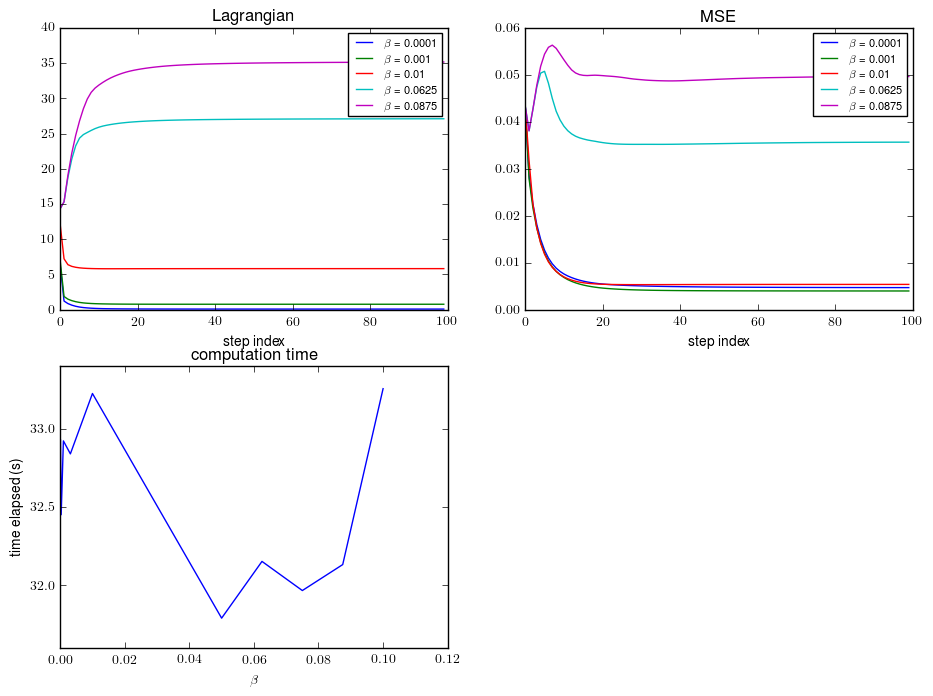

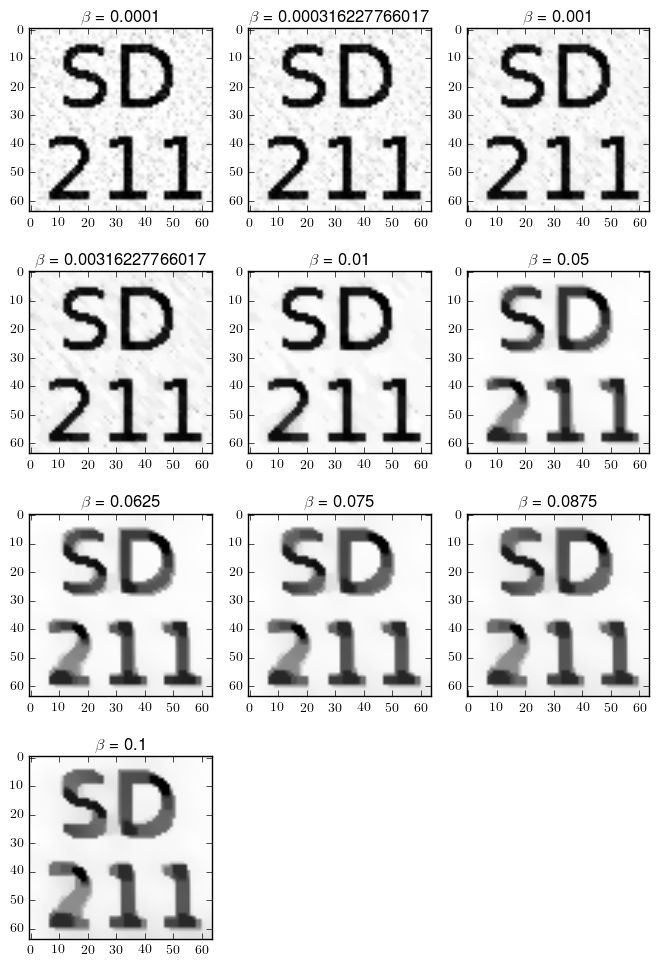

In [153]:
ρ = 0.05
#list_β = np.linspace(0.001, 0.02, 10)
list_β = np.concatenate((np.logspace(start=-4, stop=-2 , num=5, base=10), np.linspace(0.05, 0.1, 5)))
list_Lagrangian = []
list_result = []
list_MSE = []
list_time = []

for j in list_β:
    result, Lagrangian, MSE, tt = ADMM_lag_mse(γ1, γ2, z1, z2, vec, ρ, j, kmax, original.ravel())
    list_Lagrangian.append(Lagrangian)
    list_MSE.append(MSE)
    list_result.append(result)
    list_time.append(tt)
    
####################
#Plotting the results
## getting the axes
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 8))
f.delaxes(ax4)
ax1.set_title(r"Lagrangian")
ax1.set_xlabel(r"step index")
ax2.set_title(r"MSE")
ax2.set_xlabel(r"step index")
ax3.set_title(r"computation time")
ax3.set_xlabel(r"$\beta$")
ax3.set_ylabel(r"time elapsed (s)")
plotsize = 8

## lagrangian
for i in range(len(list_Lagrangian)):
    if(i%2 == 0):
        ax1.plot(list_Lagrangian[i] , label=r"$\beta$ = " + str(list_β[i]))
ax1.legend(prop={'size': plotsize})

## MSE
for i in range(len(list_MSE)):
    if(i%2 == 0):
        ax2.plot(list_MSE[i], label=r"$\beta$ = " + str(list_β[i]))
ax2.legend(prop={'size': plotsize})

## time
ax3.plot(list_β, list_time)
ax3.legend(prop={'size': plotsize})

##resulting images
ncol = 3
f, axes = plt.subplots(4, ncol, figsize=(8, 12))
for i in range(4):
    for j in range(ncol):
        if(ncol*i + j == 10):
            break
        axes[i][j].set_title(r"$\beta$ = " + str(list_β[ncol*i + j]))
        axes[i][j].imshow(np.reshape(list_result[ncol*i + j] , (K,L)), cmap='gray')
f.delaxes(axes[ncol][1])
f.delaxes(axes[ncol][2])

from this we can infer the following:

- Visually speaking, $\beta$ clearly impacts the smoothness of the pictures. the higher, the smoother.
- the ideal value clearly seems to be 0.01. It can be seen visually, and also as a minimum lagrangian.
- time is very strange, but 0.01 is ok.
- Lagrangian is very high when $\beta$ is big, and conversely very small when $\beta$ is small
- MSE grows as $\beta$ increases (logical because of the previous point)

Well, $\beta$ is what we call reuglarization and this can be seen here. this happens when the pure optimization problem does not describe well enough what we want (a smooth image).

## Impact of noise

ADMM computed in 34.35 s


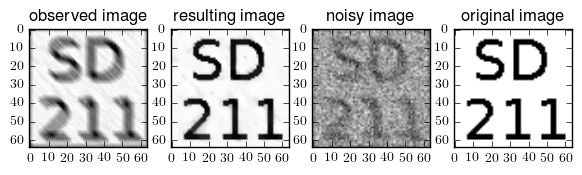

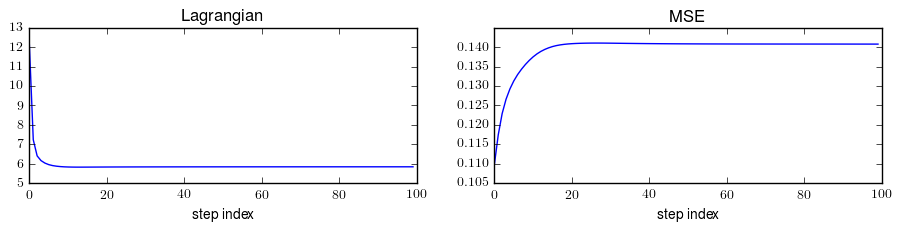

In [156]:
# adding noise
noise =  np.random.normal(0, 0.1**.5, K*L)
noisy_image_vec = vec.ravel() + noise
noisy_image = np.reshape(noisy_image_vec, (K,L))

# computing the result
ρ = 0.05
β = 0.01
kmax = 100
result, Lagrangian, MSE, tt  = ADMM_lag_mse(γ1, γ2, z1, z2, vec, ρ, β, kmax, noisy_image_vec)

# and plot
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(7,10))
ax1.set_title("observed image")
ax2.set_title("resulting image")
ax4.set_title("original image")
ax3.set_title("noisy image")
ax1.imshow(observations, cmap='gray')
ax2.imshow(np.reshape(result, (K,L)), cmap='gray')
ax3.imshow(noisy_image, cmap='gray')
ax4.imshow(original, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 2))
ax1.set_title("Lagrangian")
ax1.set_xlabel("step index")
ax2.set_title("MSE")
ax2.set_xlabel("step index")
ax1.plot(Lagrangian)
ax2.plot(MSE)

It is almost unchanged. It is great to see the algorithm is robust to noise ! The MSE is very big here only because of the noise. But the final image is just what we want.

# Conclusion

The optimization problem we set, together with the ADMM  we coded was particularly efficient at finding back the original image from the blurry image, and very robust to noise.

We studied the impact of the different hyperparameters of the problem ($\rho$ and $\beta$), and concluded that there were an optimal $\beta$ (0.01), while $\rho$ is better quite high (0.1). (Stud in the range suggested by the professor).

Optimisation can help solving unsuspected interesting real-life problems, and its applications cover signal processing.

It was cool, we did it fine, it was the last project of the year. Let's go on holidays, halelujah !!!!